In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set_style('white')

In [6]:
df = pd.read_csv('North_ML_ready.csv')
df

,CODUFMUN,COMPETEN,SUICIDE,POP_EST,RATE,CONSELHO_SOCIAL_ASSISTANT,TP_UNID_SPECIALIZED_HOSPITAL,TIPEQUIP_OTHER,SGRUPHAB_ODONTOLOGY,TP_UNID_SHORTSTAY_HOSPITAL,SGRUPHAB_GENETICS,SGRUPHAB_MENTAL_HEALTH,CONSELHO_PHYSICAL_EDUCATION,TIPEQUIP_DENTISTRY,SERV_ESP_REHABILITATION,TP_UNID_NOTIFICATION_CENTER,TP_UNID_PHARMACY,CONSELHO_PHYSICIST,CONSELHO_OPTICIAN,NULEITOS,SERV_ESP_REPRODUCTIVE_HEALTH,SGRUPHAB_URGENCY,SERV_ESP_PHYSICALTHERAPY,SGRUPHAB_CHRONIC_DISEASES,TIPO_EQP_ORAL_HEALTH,SERV_ESP_OBESITY,SERV_ESP_MENTAL_HEALTH,SGRUPHAB_CARDIOVASCULAR,TIPEQUIP_AUDIOLOGY,CONSELHO_PHARMACIST,CONSELHO_VETERINARIAN,SERV_ESP_HEMOTHERAPY,SGRUPHAB_INTERMEDIARY_CARE,SERV_ESP_ONCOLOGY,SERV_ESP_ORAL_HEALTH,SGRUPHAB_PHYLANTHROPY,SERV_ESP_NUTRITION/GASTROLOGY,SERV_ESP_TELEHEALTH,SGRUPHAB_OPHTHALMOLOGY,SERV_ESP_URGENCY,CONSELHO_MEDICAL_REGISTRATION_MAIS_MEDICOS,TP_UNID_MULTISPECIALIST_CLINIC,SERV_ESP_RARE_DISEASES,CONSELHO_PSYCHOLOGIST,SERV_ESP_ENDOCRINOLOGY,SERV_ESP_SEXUAL_VIOLENCE,TIPEQUIP_GRAPHIC_METHODS,TP_UNID_PREVENTION_CENTER,SERV_ESP_TEACHING,TP_UNID_HEALTHCARE_SURVEILLANCE,SERV_ESP_HEARING_HEALTH,TP_UNID_SPECIALIZED_EMERGENCY_ROOM,TP_UNID_MIXED_EMERGENCY_UNIT,CONSELHO_NURSING,CONSELHO_PEDAGOGY,Leitos,TP_UNID_EMERGENCY_CARE,TP_UNID_EDUCATIONAL_CENTER,TP_UNID_DIAGNOSTIC_CENTER,TP_UNID_CLINIC,SERV_ESP_COMMITTIEES,AMB_SUS,TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE,TIPO_EQP_MENTAL_HEALTH,TIPO_EQP_PRISION_HEALTH,TP_UNID_FAMILY_CENTER,TP_UNID_INDIGENOUS_CENTER,TP_UNID_GENERAL_HOSPITAL,CONSELHO_RADIOLOGY_TECHNICIAN,CONSELHO_RADIOLOGIST,TP_UNID_CENTRAL_LABORATORY,SGRUPHAB_HIV/AIDS,TIPO_EQP_HEALTH_AGENTS,SGRUPHAB_TRAUMA,SERV_ESP_PHARMACY,SGRUPHAB_AURICULAR,HOSP_SUS,SERV_ESP_TUBERCULOSIS/HANSENS_DISEASES,TP_UNID_PRIMARY_HEALTHCARE_UNIT,TP_UNID_RIVER_MOBILE_UNIT,TP_UNID_HOME_CARE,TP_UNID_HEALTH_INSURANCE,IND_SUS,TIPEQUIP_IMAGE_DIAGNOSIS,SGRUPHAB_ONCOLOGY,SERV_ESP_SMOKING,SERV_ESP_INDIGENOUS_HEALTH,PROF_SUS,SERV_ESP_NEUROLOGY,SERV_ESP_TRANSPLANT,TIPEQUIP_LIFE_MAINTAINING,SGRUPHAB_ORTHOPEDICS,TP_UNID_MOBILE_URGENCY_CARE,SERV_ESP_NEFROLOGY,SERV_ESP_PRISON,SGRUPHAB_ICU,SERV_ESP_ORTHOPEDICS,TIPEQUIP_OPTICAL_METHODS,CONSELHO_BIOMEDICINE,TP_UNID_TELEHEALTH,TP_UNID_ACCESS_CENTER,SGRUPHAB_WORKER_HEALTHCARE,TP_UNID_GENERAL_EMERGENCY_ROOM,SGRUPHAB_NUTRITION_GASTROLOGY,CONSELHO_NUTRITIONIST,TIPO_EQP_INDIGENOUS_HEALTH,CONSELHO_PHYSIOTHERAPIST_OCCUPATIONAL_THERAPIST,CONSELHO_SPEECH_THERAPIST,TP_UNID_HEALTH_DEPARTMENT,SGRUPHAB_SURGERY,SERV_ESP_SURGERY,CONSELHO_PHYSICIAN,CONSELHO_CHEMIST,TIPO_EQP_FAMILY_HEALTH,SGRUPHAB_NEUROLOGY,TP_UNID_HEALTHCARE_REGULATOR,SERV_ESP_PREGNANCY,TP_UNID_IMMUNIZATION_CENTER,SERV_ESP_OPHTHALMOLOGY,TP_UNID_MOBILE_HEATH_CARE,SGRUPHAB_PREGNANCY,SERV_ESP_BASIC_HEALTH,SERV_ESP_IMUNIZATION,SGRUPHAB_NEPHROLOGY,TIPO_EQP_PRIMARY_CARE,CONSELHO_DENTIST,TP_UNID_PUBLIC_HEALTH_LABORATORY,TP_UNID_PSYCOSOCIAL_CENTER,SERV_ESP_STI/HIV/AIDS,VINC_SUS,TP_UNID_URGENCY_CARE_REGULATOR,SERV_ESP_ADOLESCENT_HEALTH,SERV_ESP_PNEUMOLOGY,SERV_ESP_CARDIOVASCULAR,CONSELHO_BIOLOGIST,SERV_ESP_HEALTH_SURVEILLANCE,CNES,TP_UNID_SUPPLY_CENTER,CONSELHO_ECONOMIST,TP_UNID_SPECIALIST_UNIT,SGRUPHAB_TEACHING,TIPEQUIP_INFRASTRUCTURE,SERV_ESP_DIAGNOSIS,SERV_ESP_TRANSSEXUAL,SGRUPHAB_TRANSPLANT,SERV_ESP_ICU,TP_UNID_HEMOTHERAPY_CENTER,CONSELHO_STATISTICIAN,SGRUPHAB_GERIATRIC,SGRUPHAB_PHYSICAL_REHABILITATION,SGRUPHAB_OBESITY,TP_UNID_CHILDBIRTH_CENTER,RATE_SUICIDE
0,110001,200907,1,22516,4.441286,0,0,1,0,0,0,1,0,14,0,0,0,0,0,0,2,0,4,0,2,0,1,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,69,0,0,3,0,0,11,6,0,0,0,0,2,0,0,0,0,2,0,0,0,3,2,2,0,0,0,3,3,0,1,2,0,0,0,2,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,6,0,0,4,0,2,0,0,10,0,0,0,0,0,1,0,11,0,0,0,0,0,1,41858723,0,0,0,0,2,18,0,0,0,0,0,0,0,0,0,0
1,110001,201106,1,22516,4.441286,0,0,0,0,0,0,1,0,15,0,0,0,0,0,0,2,0,4,0,2,0,1,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,54,0,0,3,0,0,9,6,0,2,0,0,2,0,0,0,0,2,0,0,0,3,3,2,0,0,0,3,3,0,1,2,0,0,0,3,0,0,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,6,0,0,4,0,2,0,0,8,0,0,0,0,0,1,0,12,0,0,0,0,0,1,5458

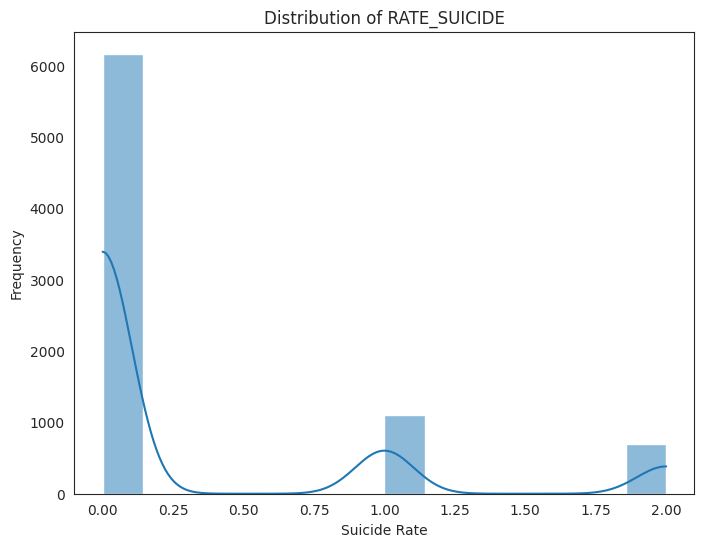

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True)  # kde adds a kernel density estimate curve
plt.title('Distribution of RATE_SUICIDE')
plt.xlabel('Suicide Rate')
plt.ylabel('Frequency')
plt.show()

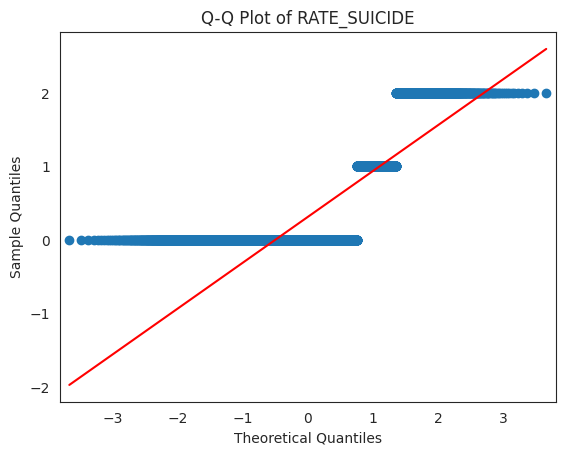

In [11]:
import statsmodels.api as sm

sm.qqplot(y, line='s')  # 's' draws a standardized line
plt.title('Q-Q Plot of RATE_SUICIDE')
plt.show()

### Train and Test sets

In [7]:
y = df['RATE_SUICIDE']
# removing some columns equivalent to the outcome or that are specific
X = df.drop(columns= ['RATE_SUICIDE', 'CODUFMUN', 'COMPETEN', 'SUICIDE', 'RATE', 'NULEITOS', 'CNES', 'POP_EST',
                      'HOSP_SUS', 'AMB_SUS', 'IND_SUS']).sort_index(axis=1)

In [ ]:
X.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7957 entries, 0 to 7956
Data columns (total 137 columns):
 #    Column                                           Non-Null Count  Dtype
---   ------                                           --------------  -----
 0    CONSELHO_BIOLOGIST                               7957 non-null   int16
 1    CONSELHO_BIOMEDICINE                             7957 non-null   int16
 2    CONSELHO_CHEMIST                                 7957 non-null   int16
 3    CONSELHO_DENTIST                                 7957 non-null   int16
 4    CONSELHO_NURSING                                 7957 non-null   int32
 5    CONSELHO_NUTRITIONIST                            7957 non-null   int16
 6    CONSELHO_OPTICIAN                                7957 non-null   int8 
 7    CONSELHO_PEDAGOGY                                7957 non-null   int8 
 8    CONSELHO_PHARMACIST                              7957 non-null   int16
 9    CONSELHO_PHYSICAL_EDUCATION            

## XGBoost

### Hyperparameter tuning

In [ ]:
xg = XGBClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [ ]:
%%time
# Defining the hyperparameter distribution
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [1000, 3000, 5000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15],
}

# Initialize lists to store results
all_y_true = []
all_y_pred = []
best_params_list = []  # Store best parameters for each fold

for train_index, test_index in kf.split(X, y):  # Stratify by y to maintain the proportion of classes in each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize GridSearchCV
    random_search = RandomizedSearchCV(
        estimator=xg,
        param_distributions=param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=kf,  # Inner cross-validation folds for GridSearchCV
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    # Get the best model and predictions
    best_xg = random_search.best_estimator_
    y_pred = best_xg.predict(X_test)

    # Store results
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    best_params_list.append(random_search.best_params_)

CPU times: user 17min 41s, sys: 8.76 s, total: 17min 50s
Wall time: 36min 51s


In [ ]:
print(f'{best_params_list[0]}\n{best_params_list[1]}\n{best_params_list[2]}\n{best_params_list[3]}\n{best_params_list[4]}')
# Extracting values for each parameter
max_depth = [params['max_depth'] for params in best_params_list]
learning_rate = [params['learning_rate'] for params in best_params_list]
subsample = [params['subsample'] for params in best_params_list]
n_estimators = [params['n_estimators'] for params in best_params_list]
colsample_bytree = [params['colsample_bytree'] for params in best_params_list]


# Calculate mean values to use as parameters
mean_max_depth = np.mean(max_depth)
learning_rate = np.mean(learning_rate)
subsample = np.mean(subsample)
mean_n_estimators = np.mean(n_estimators)
colsample_bytree = np.mean(colsample_bytree)

# Print the mean values
print(f"max_depth={mean_max_depth:.0f},")
print(f"learning_rate={learning_rate:.2f},")
print(f"subsample={subsample:.2f},")
print(f"colsample_bytree={colsample_bytree:.2f},")
print(f"n_estimators={mean_n_estimators:.0f}")

{'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
{'subsample': 0.6, 'n_estimators': 5000, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
{'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
{'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
{'subsample': 0.6, 'n_estimators': 3000, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
max_depth=13,
learning_rate=0.01,
subsample=0.68,
colsample_bytree=0.80,
n_estimators=2200


### Crossvalidation

In [ ]:
# Kfold separation and model definition
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

xg = XGBClassifier(max_depth=13,
                   learning_rate=0.01,
                   subsample=0.7,
                   colsample_bytree=0.8,
                   n_estimators=2000)

In [ ]:
%%time
# lists to store the different kfold results
all_y_true = []
all_y_pred = []
xg_all_importances = []
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Training the whole data with the best parameter using cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)

    # Storing the prediction results for each fold
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    xg_all_importances.append(xg.feature_importances_)

    # Calculating the metrics for each fold
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    # precision, recall e f1-score by class
    report = classification_report(y_test, y_pred, output_dict=True)

    # Storing the metrics
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])

# Printing the report for all folds
overall_report = classification_report(all_y_true, all_y_pred)
print("Overall report:\n", overall_report)

# Calculating the mean and standard error for the metrics of all folds
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("\n Mean and standard error:")
print(f"Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")
print(f"Precision: {mean_precision:.2f} ± {std_precision:.2f}")
print(f"Recall: {mean_recall:.2f} ± {std_recall:.2f}")
print(f"F1 Score: {mean_f1:.2f} ± {std_f1:.2f}")


Overall report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      6164
           1       0.81      0.77      0.79      1097
           2       0.91      0.87      0.89       696

    accuracy                           0.94      7957
   macro avg       0.89      0.87      0.88      7957
weighted avg       0.94      0.94      0.94      7957


 Mean and standard error:
Accuracy: 0.94 ± 0.00
Precision: 0.94 ± 0.00
Recall: 0.94 ± 0.00
F1 Score: 0.94 ± 0.00
CPU times: user 18min 55s, sys: 6.2 s, total: 19min 1s
Wall time: 2min 24s


In [ ]:
# Calculate average feature importances
average_importances = np.mean(xg_all_importances, axis=0)
sorted_indices = np.argsort(average_importances)[::-1]

print("Features and their average importances:")
for index in sorted_indices:
    print(f"{X.columns[index]}: {average_importances[index]*100:.2f}%")

Features and their average importances:
VINC_SUS: 8.58%
TIPEQUIP_IMAGE_DIAGNOSIS: 5.95%
SERV_ESP_DIAGNOSIS: 5.16%
SERV_ESP_BASIC_HEALTH: 4.79%
CONSELHO_PHYSICIAN: 3.95%
SERV_ESP_PREGNANCY: 3.94%
Leitos: 3.80%
TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE: 3.63%
TIPEQUIP_LIFE_MAINTAINING: 3.54%
PROF_SUS: 2.98%
TIPEQUIP_INFRASTRUCTURE: 2.76%
CONSELHO_NURSING: 2.71%
SERV_ESP_MENTAL_HEALTH: 2.50%
TIPEQUIP_DENTISTRY: 2.17%
TIPO_EQP_HEALTH_AGENTS: 2.12%
TIPEQUIP_GRAPHIC_METHODS: 1.95%
CONSELHO_PHARMACIST: 1.93%
TP_UNID_PRIMARY_HEALTHCARE_UNIT: 1.88%
CONSELHO_DENTIST: 1.83%
TP_UNID_PSYCOSOCIAL_CENTER: 1.75%
TP_UNID_GENERAL_HOSPITAL: 1.69%
TP_UNID_SPECIALIST_UNIT: 1.68%
SERV_ESP_URGENCY: 1.45%
CONSELHO_RADIOLOGY_TECHNICIAN: 1.44%
TIPO_EQP_ORAL_HEALTH: 1.35%
SERV_ESP_ORAL_HEALTH: 1.34%
CONSELHO_SOCIAL_ASSISTANT: 1.24%
CONSELHO_PHYSIOTHERAPIST_OCCUPATIONAL_THERAPIST: 1.17%
SERV_ESP_TUBERCULOSIS/HANSENS_DISEASES: 1.16%
SERV_ESP_PHYSICALTHERAPY: 1.15%
SERV_ESP_HEMOTHERAPY: 1.05%
TIPEQUIP_OPTICAL_METH

### Correlations of variables with rate

We used the 10 most important variables to see how they correlate with the suicide rate in the region. We used the spearman correlation since data are not normal or de correlation may not be linear.

In [16]:
from scipy.stats import kstest

statistic, p_value = kstest(y, 'norm')  # 'norm' specifies the normal distribution
print(f'Kolmogorov-Smirnov Test: Statistic = {statistic:.3f}, p-value = {p_value:.3f}\n')

if p_value > 0.05:
    print('Data appears to be normally distributed.')
else:
    print('Data does not appear to be normally distributed.)')

Kolmogorov-Smirnov Test: Statistic = 0.500, p-value = 0.000

Data does not appear to be normally distributed.)


In [ ]:
features = ['RATE',
'VINC_SUS',
'TIPEQUIP_IMAGE_DIAGNOSIS',
'SERV_ESP_DIAGNOSIS',
'SERV_ESP_BASIC_HEALTH',
'CONSELHO_PHYSICIAN',
'SERV_ESP_PREGNANCY',
'Leitos',
'TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE',
'TIPEQUIP_LIFE_MAINTAINING',
'PROF_SUS'
             ]


rename = {'RATE':'Suicide Rate',
'VINC_SUS':'SUS establishments',
'PROF_SUS':'SUS professionals',
'CONSELHO_PHYSICIAN':'Physicians',
'Leitos':'Hospital beds',
'SERV_ESP_BASIC_HEALTH':'Basic health services',
'SERV_ESP_PREGNANCY':'Pregnancy care',
'SERV_ESP_DIAGNOSIS':'Diagnostic services',
'TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE':'Multispecialty primary unit',
'TIPEQUIP_IMAGE_DIAGNOSIS':'Image diagnostic equipment',
'TIPEQUIP_LIFE_MAINTAINING':'Life support equipment'
          }

sim = sim[features].rename(columns=rename)
sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7957 entries, 0 to 7956
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Suicide Rate                 7957 non-null   float64
 1   SUS establishments           7957 non-null   int64  
 2   Image diagnostic equipment   7957 non-null   int64  
 3   Diagnostic services          7957 non-null   int64  
 4   Basic health services        7957 non-null   int64  
 5   Physicians                   7957 non-null   int64  
 6   Pregnancy care               7957 non-null   int64  
 7   Hospital beds                7957 non-null   int64  
 8   Multispecialty primary unit  7957 non-null   int64  
 9   Life support equipment       7957 non-null   int64  
 10  SUS professionals            7957 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 683.9 KB


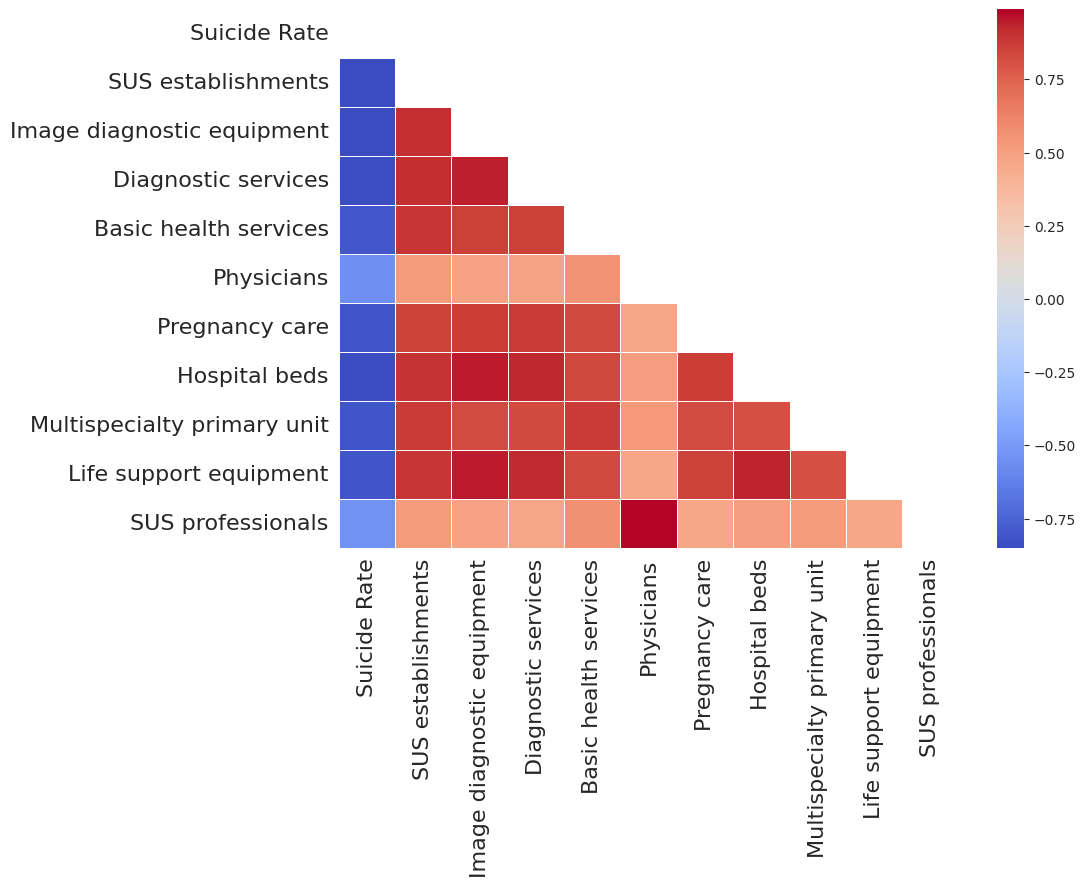

In [ ]:
# computando a matrix de correlação das variaveis (todas por todas)
corr = sim.corr(method='spearman')

# retirando o triangulo superior da matrix (ele é espelhado a parte inferior)
mask = np.triu(np.ones_like(corr, dtype= bool))
f, ax = plt.subplots(figsize=(10, 7))

# gerando a matrix
sns.heatmap(corr, mask= mask, linewidth= 0.5, cmap='coolwarm',);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()